In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv
/kaggle/input/porto-seguro-safe-driver-prediction/train.csv
/kaggle/input/porto-seguro-safe-driver-prediction/test.csv


## Data Description
In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv("/kaggle/input/porto-seguro-safe-driver-prediction/train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
rows = train.shape[0]
cols = train.shape[1]
print(rows,cols)

595212 59


## **Data Quality Checks**

Null or missing values check

In [10]:
train.isnull().any()
train.isnull().any().any()

False

* there are no null on the table
* However, "Values of -1 indicate that the feature was missing from the observation".

In [11]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

"Missingno" package which is a most useful and convenient tool in visualising missing values in the dataset, so check it out.

<AxesSubplot:>

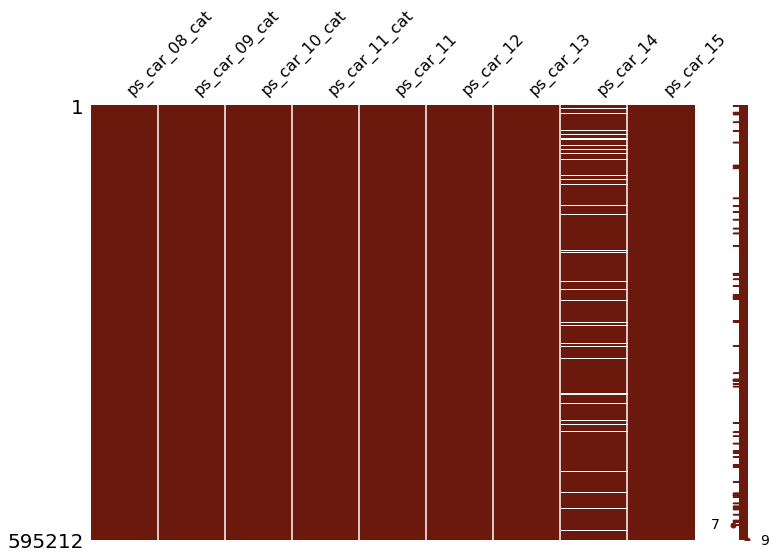

In [17]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:,30:39], figsize=(12,8), color=(0.42,0.1,0.05))

For the 7 null columns that we are able to observe, they are hence listed here as follows:

**ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14**

Most of the missing values occur in the columns suffixed with _cat. One should really take further note of the columns ps_reg_03, ps_car_03_cat and ps_car_05_cat. Evinced from the ratio of white to dark bands, it is very apparent that a big majority of values are missing from these 3 columns, and therefore a blanket replacement of -1 for the nulls might not be a very good strategy.

## Target variable inspection

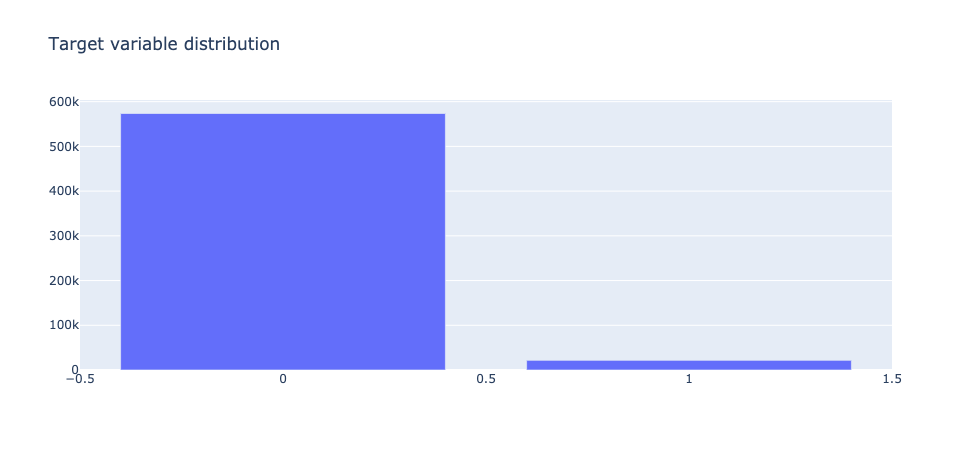

In [18]:
data = [
    go.Bar(
        x = train["target"].value_counts().index.values,
        y = train["target"].value_counts().values,
        text = 'Distribution of target variable'
    )
]

layout = go.Layout(
    title = 'Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

the target variable is rather imbalanced so it might be something to keep in mind. An imbalanced target will prove quite

## Datatype check

This check is carried out to see what kind of datatypes the train set is comprised of : integers or characters or floats just to gain a better overview of the data we were provided with. One trick to obtain counts of the unique types in a python sequence is to use the Counter method, when you import the Collections module as follows:

In [19]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

Here I shall simplify this a bit further just by looking at float values (probably only the continuous features) and integer datatypes (binary, categorical and ordinal features).

In [25]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])
train_float.head()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
0,0.7,0.2,0.718070,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2
1,0.8,0.4,0.766078,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3
2,0.0,0.0,-1.000000,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1
3,0.9,0.2,0.580948,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1
4,0.7,0.6,0.840759,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0


## Correlation plots
generate some linear correlation plots just to have a quick look at how a feature is linearly correlated to the next.

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

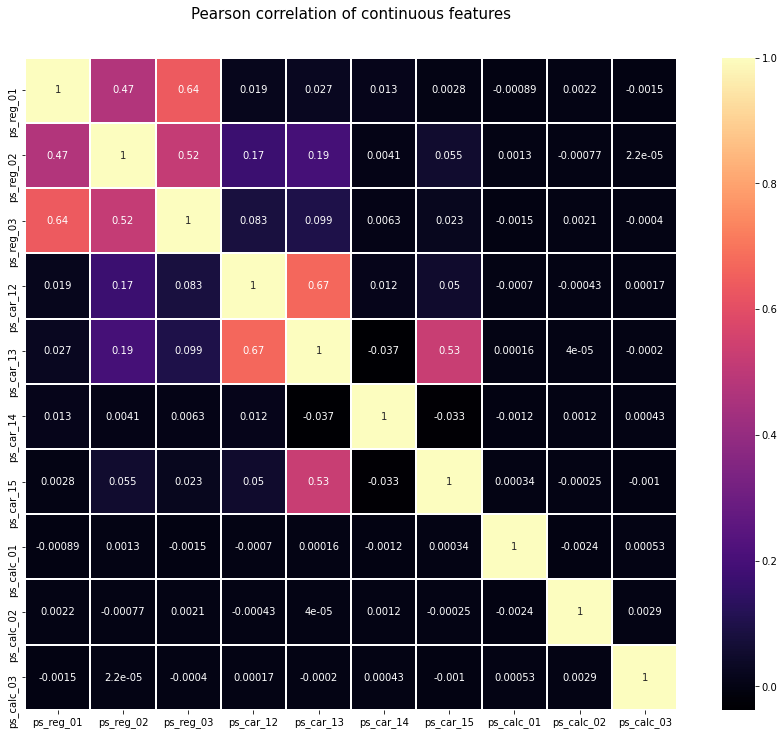

In [34]:
# correlation of float features
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,\
            cmap=colormap, linecolor='white', annot=True)

From the correlation plot, we can see that the majority of the features display zero or no correlation to one another. This is quite an interesting observation that will warrant our further investigation later down. For now, the paired features that display a positive linear correlation are listed as follows:

(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

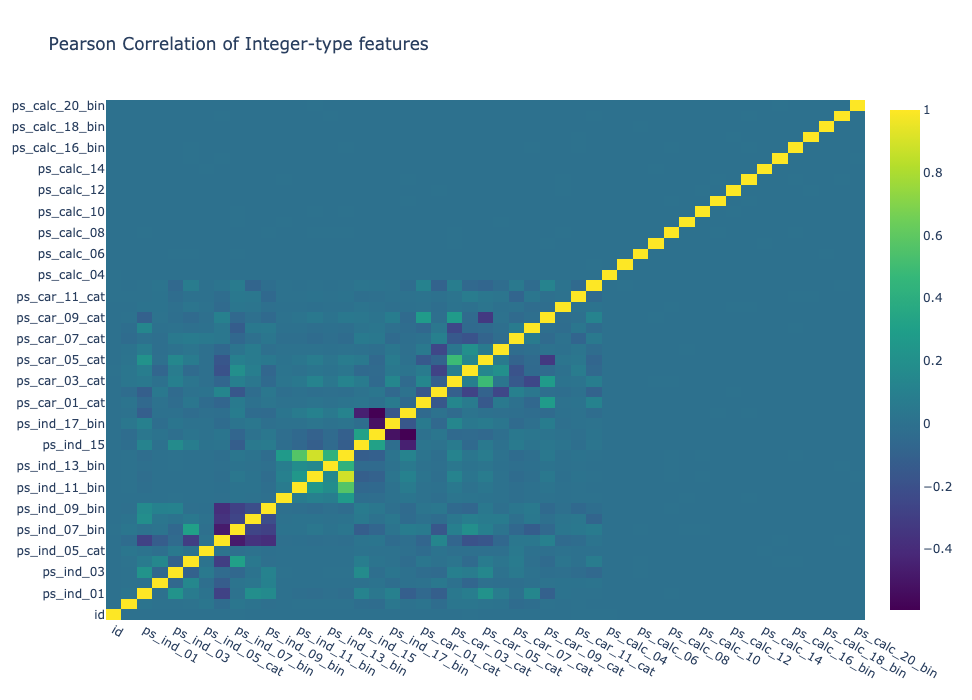

In [32]:
# correlation of integer features
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x= train_int.columns.values,
        y= train_int.columns.values,
        colorscale= 'Viridis',
        reversescale= False,
        
        opacity= 1.0
    )
]

layout = go.Layout(
    title = 'Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='',nticks=36),
    yaxis = dict(ticks=''),
    width = 900, height = 700
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

Similarly, we can observe that there are a huge number of columns that are not linearly correlated with each other at all, evident from the fact that we observe quite a lot of 0 value cells in our correlation plot. This is quite a useful observation to us, especially if we are trying to perform dimensionality reduction transformations such as Principal Component Analysis (PCA), this would require a certain degree of correlation . We can note some features of interest are as follows:

**Negatively correlated features** : ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

One interesting aspect to note is that in our earlier analysis on nullity, ps_car_03_cat and ps_car_05_cat were found to contain many missing or null values. Therefore it should come as no surprise that both these features show quite a strong positive linear correlation to each other on this basis, albeit one that may not really reflect the underlying truth for the data.

## Mutual Information plots
Mutual information is another useful tool as it allows one to inspect the mutual information between the target variable and the corresponding feature it is calculated against. For classification problems, we can conveniently call Sklearn's mutual_info_classif method which measures the dependency between two random variables and ranges from zero (where the random variables are independent of each other) to higher values (indicate some dependency). This therefore will help give us an idea of how much information from the target may be contained within the features.

The sklearn implementation of the mutual_info_classif function tells us that it relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances

In [35]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


## Binary Features Inspection
Another aspect of the data that we may want to inspect would be the columns that only contain binary values, i.e where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical plotly barplot of these binary values as follows:

In [37]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

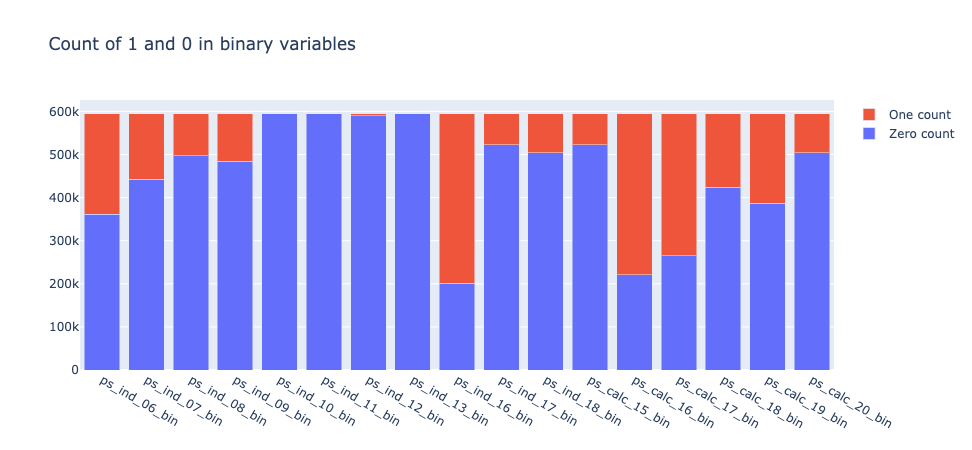

In [38]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

Here we observe that there are 4 features : ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by zeros. This begs the question of whether these features are useful at all as they do not contain much information than the other class vis-a-vis the target

## Feature Importance via Random Forest

Let us now implement a Random Forest model where we fit the training data with a Random Forest Classifier and look at the ranking of the features after the model has finished training. This is a quick way of using an ensemble model (ensemble of weak decision tree learners applied under Bootstrap aggregated) which does not require much parameter tuning in obtaining useful feature importances and is also pretty robust to target imbalances. We call the Random Forest as follows:

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, \
                            min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id','target'], axis=1), train.target)
features=train.drop(['id','target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [42]:
print(features)
print(rf)
print(rf.feature_importances_)

['ps_ind_01' 'ps_ind_02_cat' 'ps_ind_03' 'ps_ind_04_cat' 'ps_ind_05_cat'
 'ps_ind_06_bin' 'ps_ind_07_bin' 'ps_ind_08_bin' 'ps_ind_09_bin'
 'ps_ind_10_bin' 'ps_ind_11_bin' 'ps_ind_12_bin' 'ps_ind_13_bin'
 'ps_ind_14' 'ps_ind_15' 'ps_ind_16_bin' 'ps_ind_17_bin' 'ps_ind_18_bin'
 'ps_reg_01' 'ps_reg_02' 'ps_reg_03' 'ps_car_01_cat' 'ps_car_02_cat'
 'ps_car_03_cat' 'ps_car_04_cat' 'ps_car_05_cat' 'ps_car_06_cat'
 'ps_car_07_cat' 'ps_car_08_cat' 'ps_car_09_cat' 'ps_car_10_cat'
 'ps_car_11_cat' 'ps_car_11' 'ps_car_12' 'ps_car_13' 'ps_car_14'
 'ps_car_15' 'ps_calc_01' 'ps_calc_02' 'ps_calc_03' 'ps_calc_04'
 'ps_calc_05' 'ps_calc_06' 'ps_calc_07' 'ps_calc_08' 'ps_calc_09'
 'ps_calc_10' 'ps_calc_11' 'ps_calc_12' 'ps_calc_13' 'ps_calc_14'
 'ps_calc_15_bin' 'ps_calc_16_bin' 'ps_calc_17_bin' 'ps_calc_18_bin'
 'ps_calc_19_bin' 'ps_calc_20_bin']
RandomForestClassifier(max_depth=8, max_features=0.2, min_samples_leaf=4,
                       n_estimators=150, n_jobs=-1, random_state=0)
[0.01686435 0.01

#### Plot.ly Scatter Plot of feature importances

Having trained the Random Forest, we can obtain the list of feature importances by invoking the attribute "featureimportances" and plot our next Plotly plot, the Scatter plot.

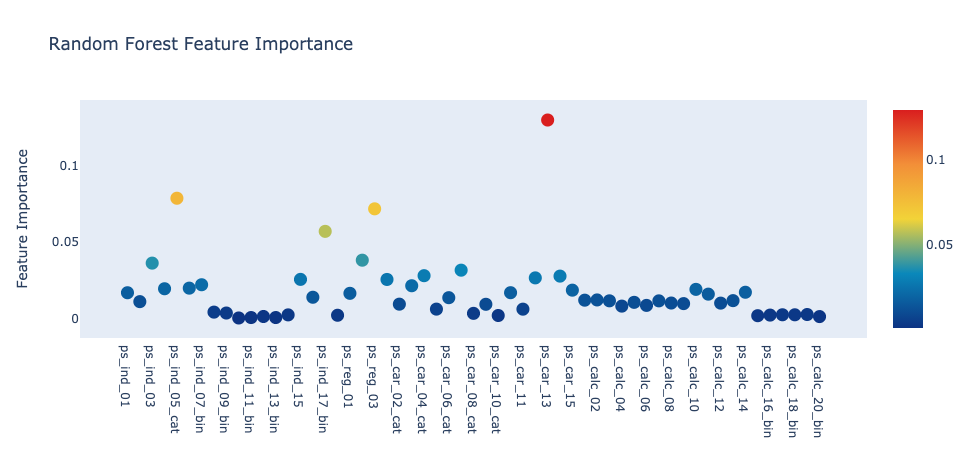

In [43]:
# Scatter plot
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode = 'markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale = 'Portland',
        showscale = True
    ),
    text = features
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    xaxis = dict(
        ticklen = 5,
        showgrid = False,
        zeroline = False,
        showline = False
    ),
    yaxis = dict(
        title = 'Feature Importance',
        showgrid = False,
        zeroline = False,
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='sctter2021')

In [44]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse=False)))

In [58]:
sorted(zip(rf.feature_importances_, features), reverse=True)[:10]

[(0.12972589668605977, 'ps_car_13'),
 (0.07861381065229754, 'ps_ind_05_cat'),
 (0.07169756523163816, 'ps_reg_03'),
 (0.056972129046208644, 'ps_ind_17_bin'),
 (0.038131333126062074, 'ps_reg_02'),
 (0.036219170535060755, 'ps_ind_03'),
 (0.031616018789628386, 'ps_car_07_cat'),
 (0.028014375170701815, 'ps_car_04_cat'),
 (0.027730687462900114, 'ps_car_14'),
 (0.026575212817247448, 'ps_car_12')]

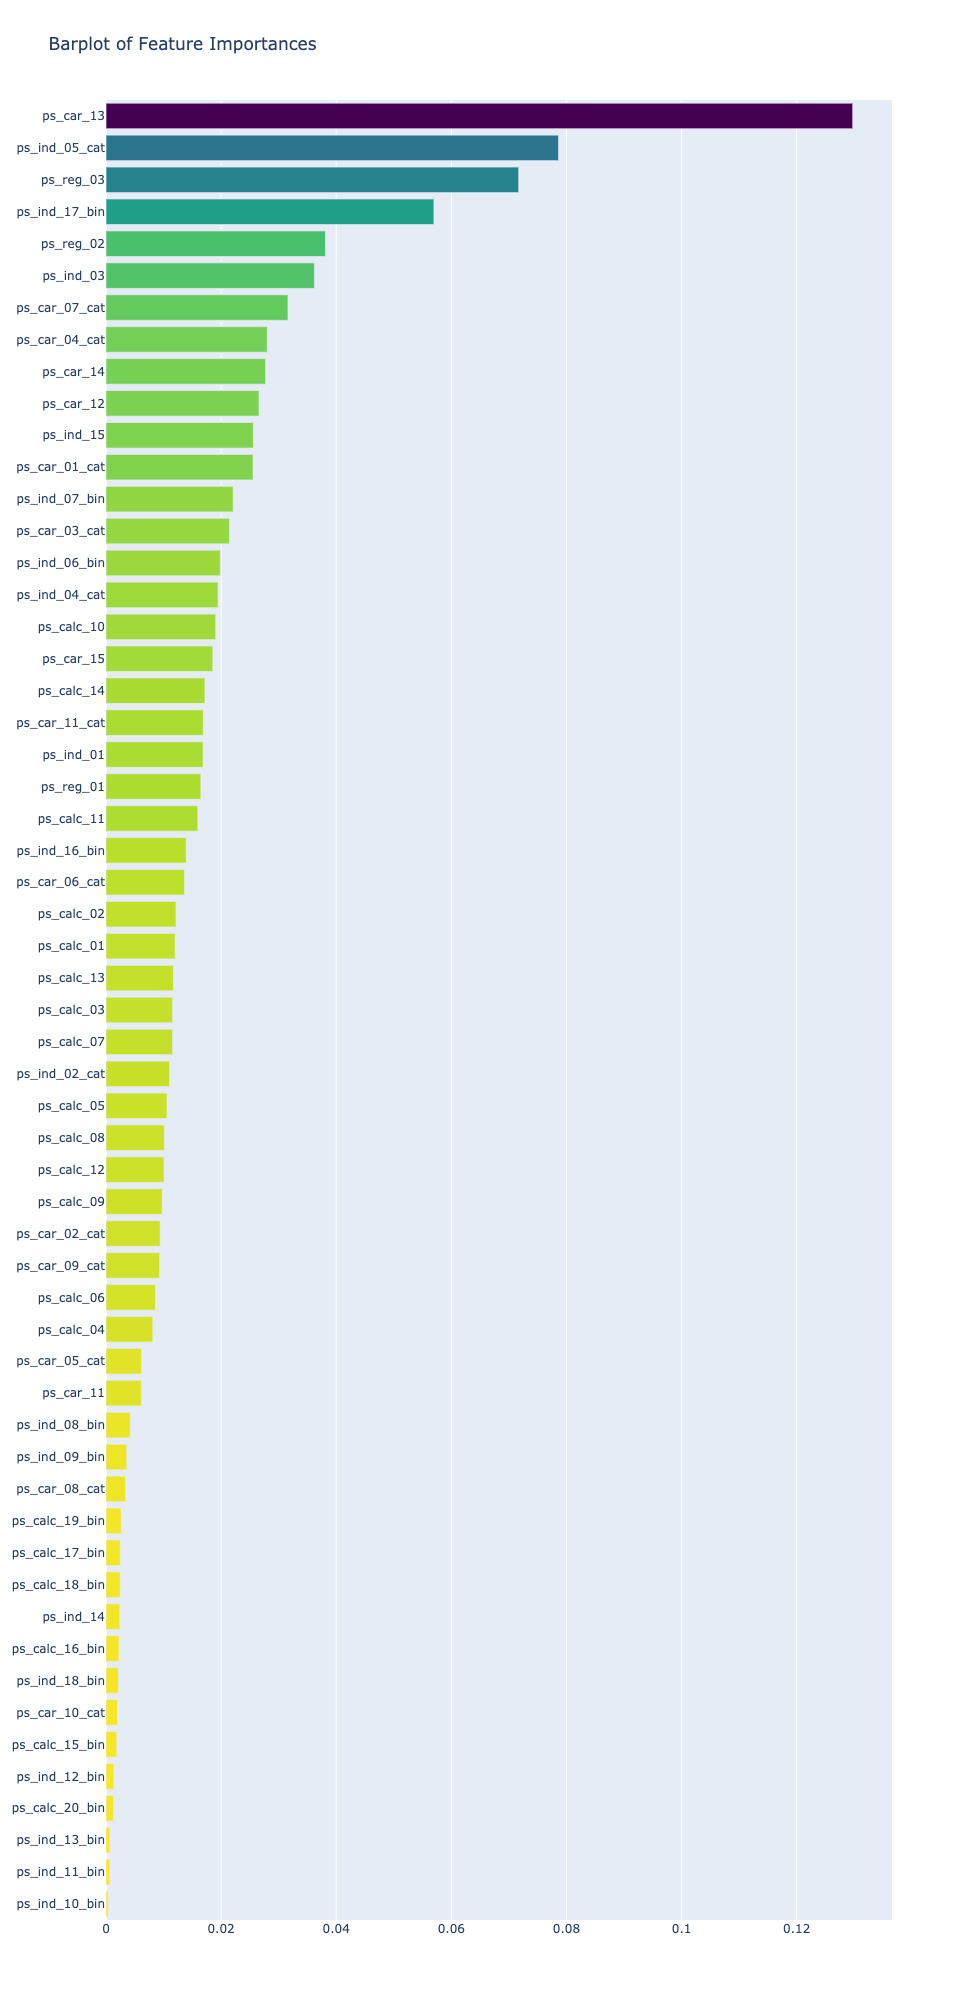

In [59]:
trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale='Viridis',
        reversescale = True
    ),
    name = 'Random Forest Feature Importance',
    orientation = 'h',
)

layout = dict(
    title = 'Barplot of Feature Importances',
    width = 900, height = 2000,
    yaxis = dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    )
)
fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Decision Tree visualisation

One other interesting trick or technique oft used would be to visualize the tree branches or decisions made by the model. For simplicity, I fit a decision tree (of max_depth = 3) and hence you only see 3 levels in the decision branch, use the export to graph visualization attribute in sklearn "export_graphviz" and then export and import the tree image for visualization in this notebook.

In [60]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

In [63]:
decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id','target'],axis=1), train.target)

# Export our trained model as a .dot file
with open('tree1.dot', 'w') as f:
    f = tree.export_graphviz(decision_tree,
                            out_file=f,
                            max_depth=4,
                            impurity=False,
                            feature_names = train.drop(['id','target'], axis=1).columns.values,
                            class_names = ['No','Yes'],
                            rounded = True,
                            filled = True)


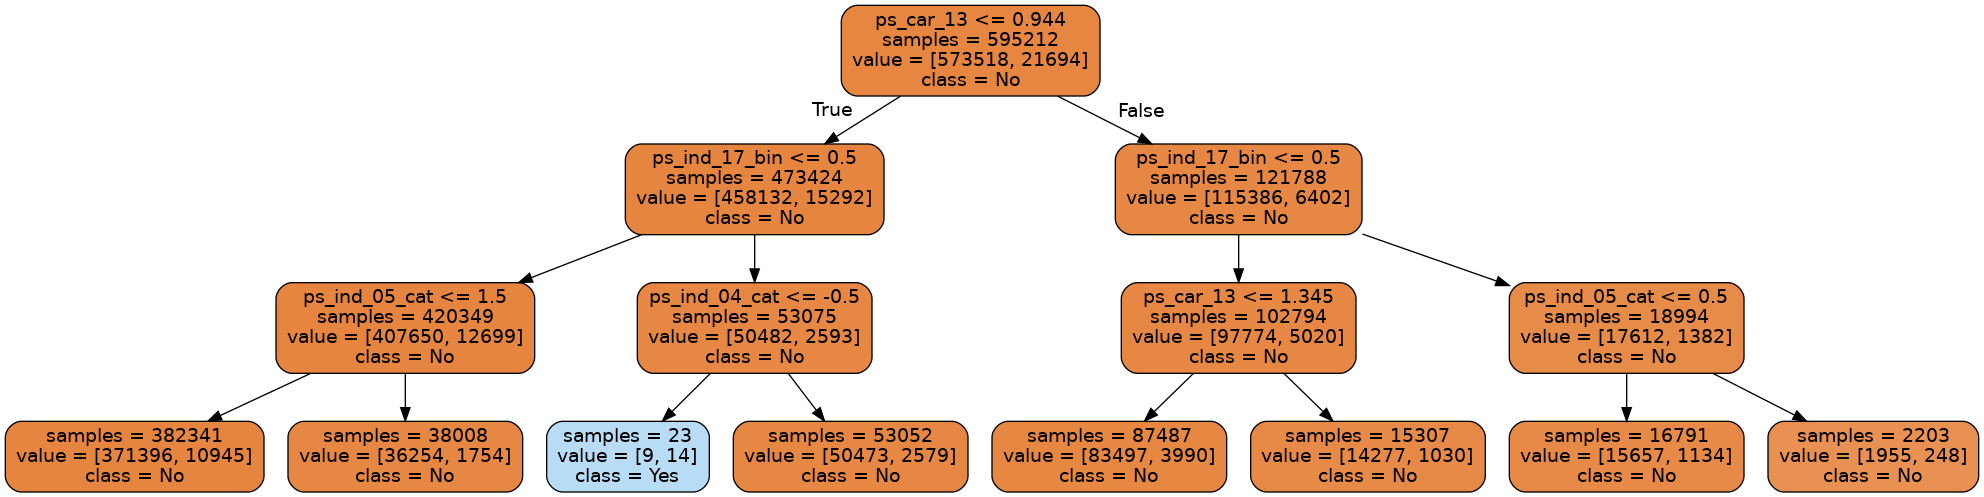

In [64]:
# convert .dot to .png
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open('tree1.png')
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage('sample-out.png',)

### Feature Importance Via Gradient Boostring Model

Just for curiosity, let us try another learning method in getting our feature importances. This time, we use a Gradient Boosting classifier to fit to the training data . Gradient Boosting proceeds in a forward stage-wise fashion, where at each stage regression tress are fitted on the gradient of the loss function (which defaults to the deviance in Sklearn implementation).

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, \
                                min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id','target'],axis=1), train.target)
features = train.drop(['id','target'],axis=1).columns.values
print("-----Training Done-----")

-----Training Done-----


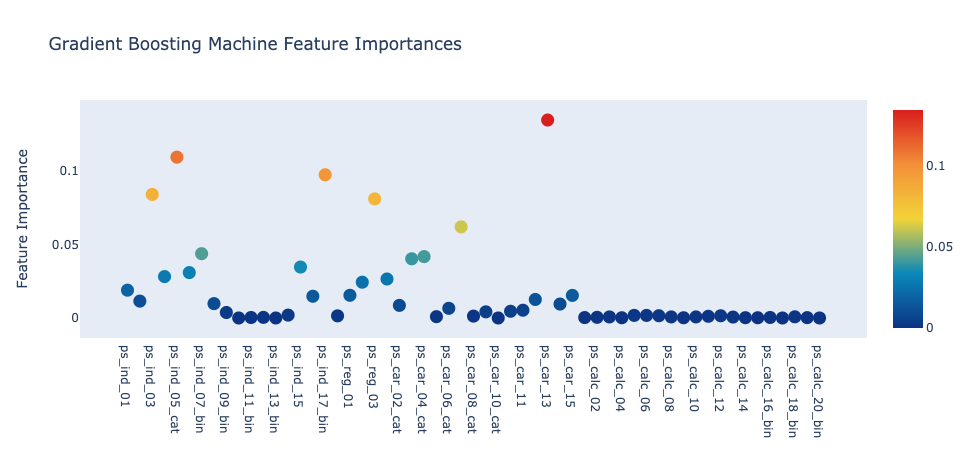

In [67]:
# Scatter plot
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = gb.feature_importances_,
        colorscale = 'Portland',
        showscale = True
    
    ),
    text = features,
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = "Gradient Boosting Machine Feature Importances",
    hovermode = 'closest',
    xaxis = dict(
        ticklen=5,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    yaxis = dict(
        title='Feature Importance',
        showgrid = False,
        zeroline = False,
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename="scatter2021")

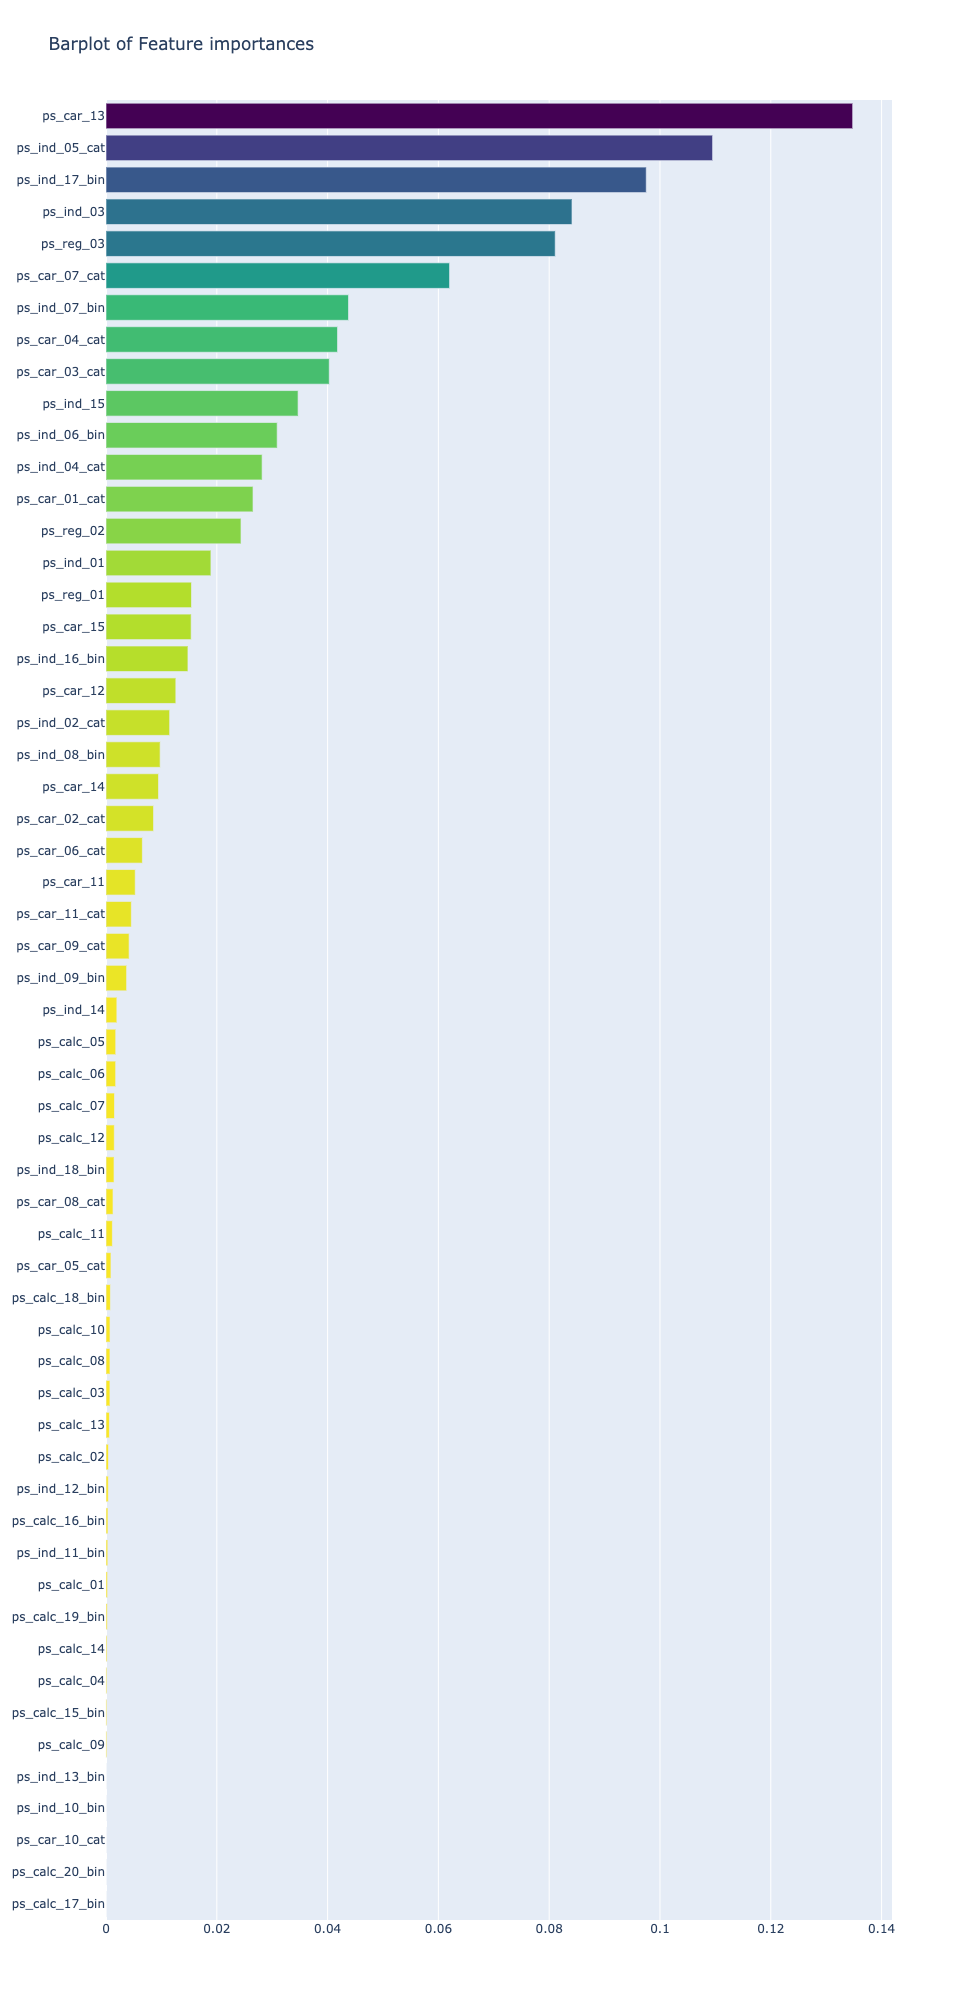

In [68]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

Interestingly we observe that in both Random forest and Gradient Boosted learning models, the most important feature that both models picked out was the column : ps_car_13.

This particular feature warrants further investigation so let us conduct a deep-dive into it.

## Conclusion
We have performed quite an extensive inspection of the Porto Seguro dataset by inspecting for null values and data quality, investigated linear correlations between features, inspected some of the feature distributions as well as implemented a couple of learning models (Random forest and Gradient Boosting classifier) so as to identify features that the models deemed important.